# Kernel Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'blue'])

## SVM SMO implementation

SMO SVM paper: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf

KKT conditions:
\begin{align*}
    \alpha_i = 0 \leftrightarrow y_i \hat{y}_i \geq 1\\
    0 < \alpha_i < C \leftrightarrow y_i \hat{y}_i = 1\\
    \alpha_i = C \leftrightarrow y_i \hat{y}_i \leq 1\\
\end{align*}
Using proposition logic this becomes the conditional:
\begin{align*}
    &(\alpha_i = 0 \rightarrow y_i \hat{y}_i \geq 1) \land (\alpha_i = 0 \leftarrow y_i \hat{y}_i \geq 1) \land\\
    &(0 < \alpha_i < C \rightarrow y_i \hat{y}_i = 1) \land (0 < \alpha_i < C \leftarrow y_i \hat{y}_i = 1) \land\\
    &(\alpha_i = C \rightarrow y_i \hat{y}_i \leq 1) \land (\alpha_i = C \leftarrow y_i \hat{y}_i \leq 1)
\end{align*}
with the rule $p \rightarrow q \implies \neg p \lor q$, this becomes:
\begin{align*}
    &(\alpha_i \neq 0 \lor y_i \hat{y}_i \geq 1) \land (\alpha_i = 0 \lor y_i \hat{y}_i < 1) \land\\
    &((\alpha_i < 0 \land \alpha_i > C) \lor y_i \hat{y}_i = 1) \land (0 < \alpha_i < C \lor y_i \hat{y}_i \neq 1) \land\\
    &(\alpha_i \neq C \lor y_i \hat{y}_i \leq 1) \land (\alpha_i = C \lor y_i \hat{y}_i > 1)
\end{align*}
This gets reduced to the form:

$((\hat{y}_i - y_i)y_i \geq 0 \lor \alpha_i \geq C) \land ((\hat{y}_i - y_i)y_i \leq 0 \lor \alpha_i \leq 0)$

In [4]:
class SVM:
    def __init__(self, C=1, epsilon=1e-4, max_iter=10, kernel='rbf', sigma=1, poly_d=2, poly_c=1):
        self.C = C
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.kernel = kernel
        self.sigma = sigma # only relevant for rbf kernel
        self.poly_c = poly_c # regularisation only relevant for polynomial kernel
        self.poly_d = poly_d # only relevant for polynomial kernel
        self.init_params()
    
    def init_params(self):
        self.X = None
        self.y = None
        self.alphas = None
        self.w0 = 0

    def K(self, a, b):
        # if a has shape (d, ), change to (1, d), i.e., a^T
        if len(a.shape) <= 1: 
            a = a[None, ...]

        # if b is vec, this is just dot(a, b), if b is matrix (N, d), its transpose gives all dot products
        if self.kernel == 'linear':
            return a @ b.T
        elif self.kernel == 'poly':
            return (a @ b.T + self.poly_c)**self.poly_d
        elif self.kernel == 'rbf':
            # if b is vec (d, ), change to (1, d), i.e., b^T
            if len(b.shape) <= 1: 
                b = b[None, ...]
            # add new axis to b which yields (1, d, 1), transpose last two axes, which yields (1, 1, d)
            # if a is matrix with shape (N, d), then this broadcasts (N, d) - (1, 1, d) = (1, N, d)
            # if a is vec with shape (1, d), then this broadcasts (1, d) - (1, 1, d) = (1, 1, d)
            # norm is computed on axis 2, which results in (1, N), and transpose is returned which is (N, 1)
            return np.exp(-np.linalg.norm(a - np.transpose(b[..., None], axes=(0, 2, 1)), axis=2)**2 / (2 * self.sigma**2)).T
        
    def g(self, x):
        # w = sum_t a^t y^t x^t, thus, w^T x + w0 = sum_t a^t y^t (x^t)^T x + w0, where (x^t)^T x is linear kernel
        return (self.alphas * self.y) @ self.K(self.X, x) + self.w0

    def fit(self, X, y):
        N = y.shape[0]
        self.X = X
        self.y = y
        self.alphas = np.zeros(N)
        self.w0 = 0
        
        iter = 0
        while iter < self.max_iter:
            alphas_changed = 0

            for i in range(N):

                E_i = self.g(X[i]) - y[i]

                ### KKT conditions check
                # a_i = self.alphas[i]
                # y_pred = self.g(X[i])
                # y_true = y[i]
                # C = self.C
                # if ((a_i != 0 or y_true*y_pred >= 1) and (a_i == 0 or y_true*y_pred < 1)) and \
                #     (((a_i < 0 and a_i > C) or y_true*y_pred == 1) and (0 < a_i < C or y_true*y_pred != 1)) and \
                #     ((a_i != C or y_true*y_pred <= 1) and (a_i == C or y_true*y_pred > 1)): continue

                if (E_i * y[i] >= -self.epsilon or self.alphas[i] >= self.C) and \
                    (E_i * y[i] <= self.epsilon or self.alphas[i] <= 0): continue

                # choose random j, such that j != i
                j = np.random.randint(0, N)
                while j == i:
                    j = np.random.randint(0, N)

                # for convenience:
                a_i = self.alphas[i]; a_j = self.alphas[j]
                y_i = y[i]; y_j = y[j]
                x_i = X[i]; x_j = X[j]

                # lower-upper bound
                if y_i != y_j:
                    L = max(0, a_j - a_i)
                    H = min(self.C, self.C + a_j - a_i)
                else:
                    L = max(0, a_j + a_i - self.C)
                    H = min(self.C, a_j + a_i)
                
                # check if lower and upper bound is equal
                if np.abs(L-H) < self.epsilon: continue

                # error between svm output and y
                E_i = self.g(x_i) - y_i
                E_j = self.g(x_j) - y_j

                # if eta is not negative, we continue
                eta = -self.K(x_i, x_i) - self.K(x_j, x_j) + 2 * self.K(x_i, x_j)
                if eta >= 0: continue

                # compute new a_j and clip it against [L, H] bounds
                a_jn = a_j - y_j * (E_i - E_j)/eta
                a_jn = H if a_jn > H else L if a_jn < L else a_jn

                # if new a_j is same as old a_j, then continue
                if np.abs(a_j - a_jn) < self.epsilon: continue

                # compute new a_i
                s = y_i * y_j
                a_in = a_i + s * (a_j - a_jn)

                # compute new w0
                b_i = self.w0 - E_i - y_i * (a_in - a_i) * self.K(x_i, x_i) - y_j * (a_jn - a_j) * self.K(x_i, x_j)
                b_j = self.w0 - E_j - y_i * (a_in - a_i) * self.K(x_i, x_j) - y_j * (a_jn - a_j) * self.K(x_j, x_j)
                self.w0 = b_i if 0 < a_in < self.C else \
                          b_j if 0 < a_jn < self.C else \
                         (b_i + b_j)/2
                
                self.alphas[i] = a_in
                self.alphas[j] = a_jn

                # values successfully updated
                alphas_changed += 1

            if alphas_changed == 0:
                iter += 1
            else:
                iter = 0
        
        support_vectors = self.alphas > 0
        self.X = self.X[support_vectors]
        self.y = self.y[support_vectors]
        self.alphas = self.alphas[support_vectors]

        return self

    def predict(self, X):
        return np.sign(self.g(X))


## Simple example

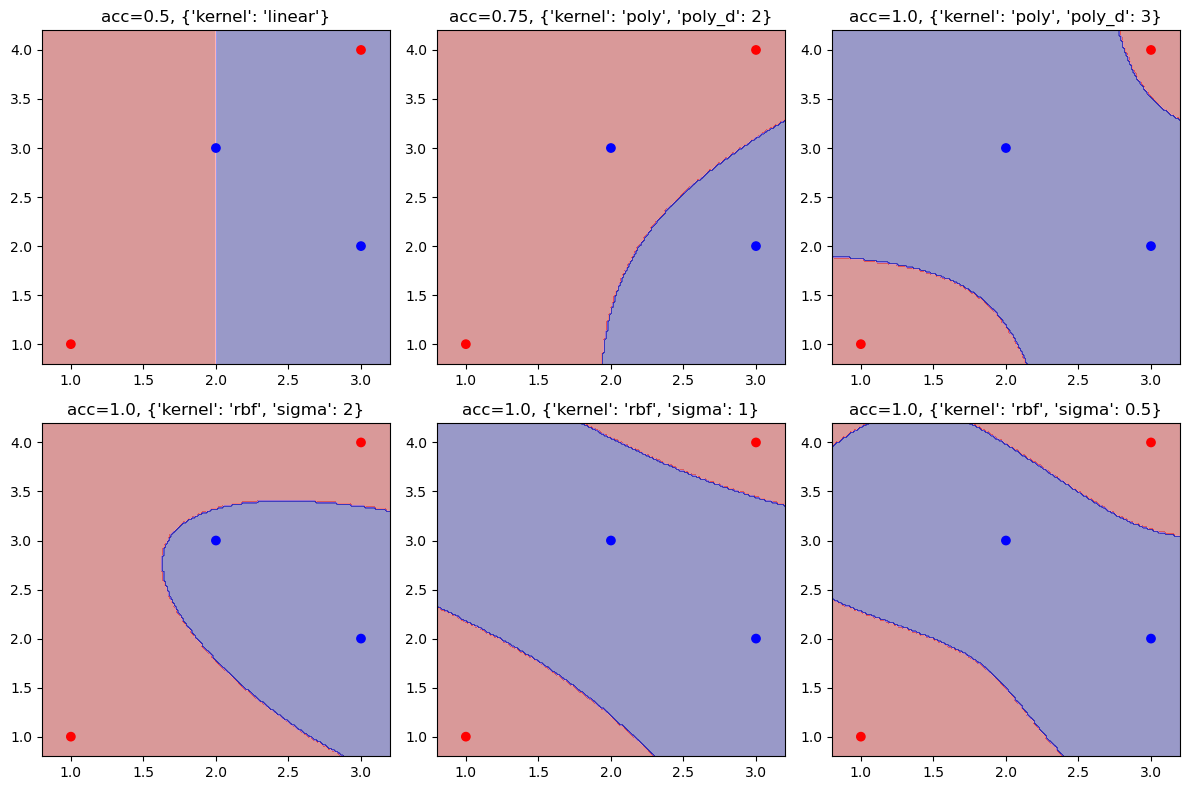

In [5]:
X = np.array([
    [1, 1],
    [2, 3],
    [3, 4],
    [3, 2]
])
y = np.array([-1, 1, -1, 1])

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

param_grid = [
    {'kernel': 'linear'},
    {'kernel': 'poly', 'poly_d': 2},
    {'kernel': 'poly', 'poly_d': 3},
    {'kernel': 'rbf', 'sigma': 2},
    {'kernel': 'rbf', 'sigma': 1},
    {'kernel': 'rbf', 'sigma': 0.5},
]

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
XX, YY = np.meshgrid(np.linspace(x_min, x_max, 200),
                    np.linspace(y_min, y_max, 200))
D = np.vstack((XX.flatten(), YY.flatten())).T

for params, ax in zip(param_grid, axes):
    # pass params dict as **kwargs
    svm = SVM(**params).fit(X, y)

    y_pred = svm.predict(D)
    # y_pred = svm.g(D)
    y_pred = y_pred.reshape(XX.shape)
    acc = np.sum(svm.predict(X) == y)/y.shape[0]

    ax.set_title(f"{acc=}, {params}")
    ax.contourf(XX, YY, y_pred, alpha=.4, cmap='seismic_r')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])

plt.tight_layout()

## Synthetic dataset 1

<AxesSubplot: >

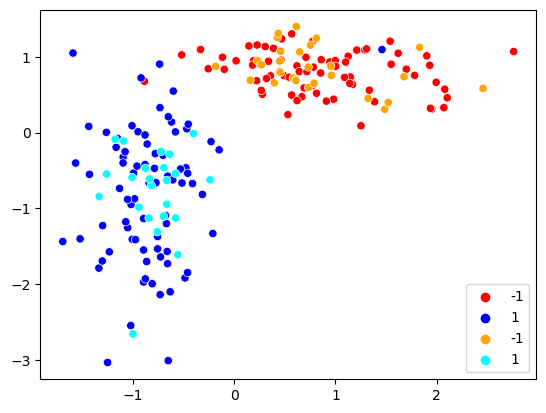

In [6]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=1
)
y = y*2-1
X = (X - X.mean())/X.std()

X_test = X[:50, :]
y_test = y[:50]
X = X[50:, :]
y = y[50:]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['r', 'b'])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette=['orange', 'cyan'])

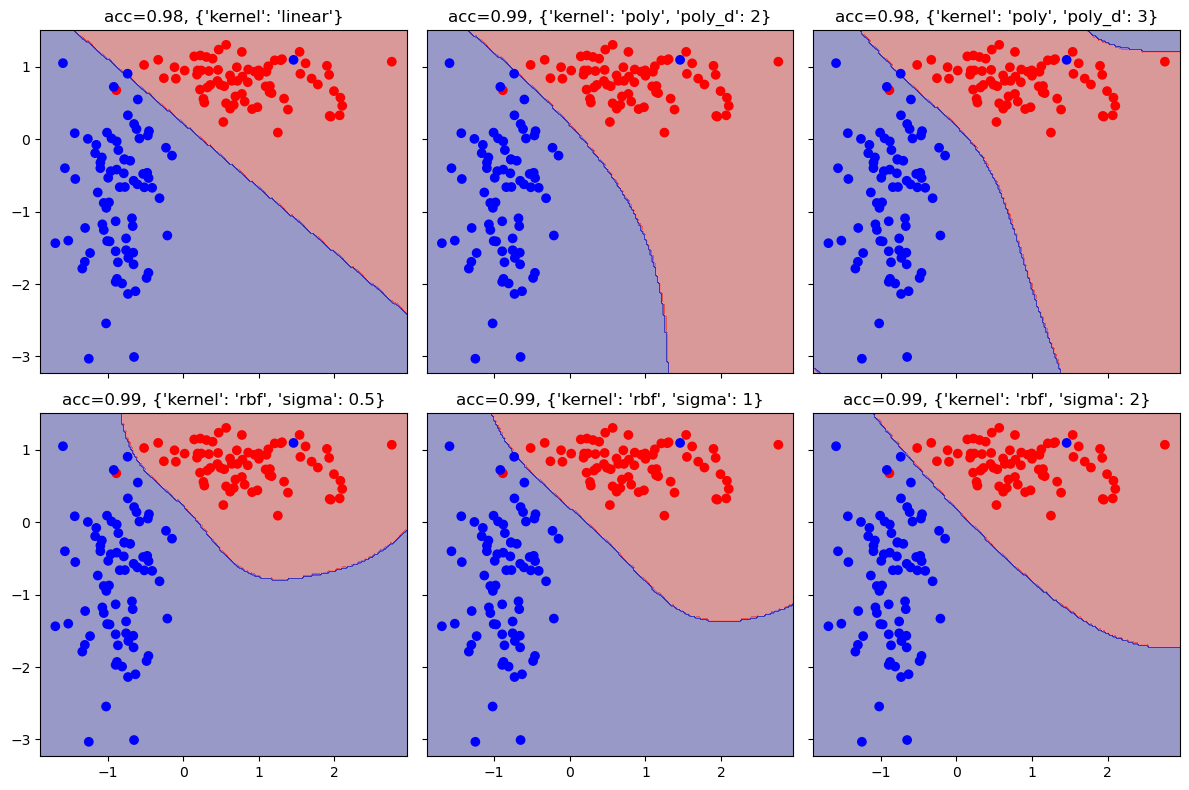

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

param_grid = [
    {'kernel': 'linear'},
    {'kernel': 'poly', 'poly_d': 2},
    {'kernel': 'poly', 'poly_d': 3},
    {'kernel': 'rbf', 'sigma': 0.5},
    {'kernel': 'rbf', 'sigma': 1},
    {'kernel': 'rbf', 'sigma': 2},
]

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
XX, YY = np.meshgrid(np.linspace(x_min, x_max, 200),
                    np.linspace(y_min, y_max, 200))
D = np.vstack((XX.flatten(), YY.flatten())).T

best_acc = 0
best_svm = None
for params, ax in zip(param_grid, axes):
    # pass params dict as **kwargs
    svm = SVM(**params).fit(X, y)

    y_pred = svm.predict(D)
    y_pred = y_pred.reshape(XX.shape)
    acc = np.sum(svm.predict(X) == y)/y.shape[0]
    if acc > best_acc:
        best_acc = acc
        best_svm = svm

    ax.set_title(f"{acc=:.2f}, {params}")
    ax.contourf(XX, YY, y_pred, alpha=.4, cmap='seismic_r')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])

plt.tight_layout()

In [15]:
acc = np.sum(best_svm.predict(X_test) == y_test)/y_test.shape[0]
acc, best_svm.kernel

(0.94, 'rbf')

## Synthetic dataset 2

Shape of X (200, 2)
Shape of y (200,)


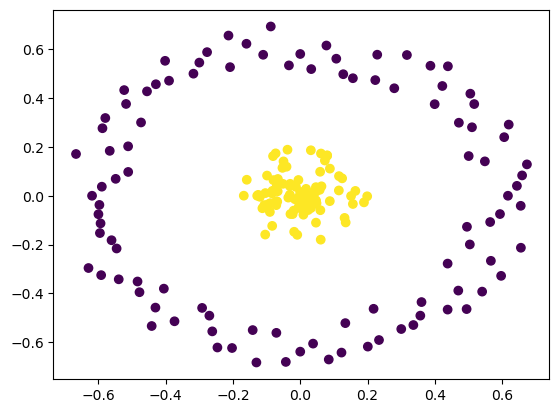

In [16]:
def generate_dummy_circle_data(num_points):
    r = np.random.uniform(0,0.2,num_points)
    theta = np.random.uniform(0,2*np.pi,num_points)
    inner_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T
    
    r = np.random.uniform(0.5,0.7,num_points)
    theta = 2*np.pi*np.arange(num_points)/num_points
    outer_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T

    X = np.concatenate((inner_circle,outer_circle),axis=0)
    y = np.concatenate((np.ones(num_points),-np.ones(num_points)),axis=0)
    
    randIdx = np.arange(X.shape[0])
    np.random.shuffle(randIdx)
    
    X = X[randIdx]
    y = y[randIdx].astype(int)
    
    return X, y
X,y = generate_dummy_circle_data(100)

print("Shape of X", X.shape)
print("Shape of y", y.shape)

plt.scatter(X[:,0],X[:,1],c=y)

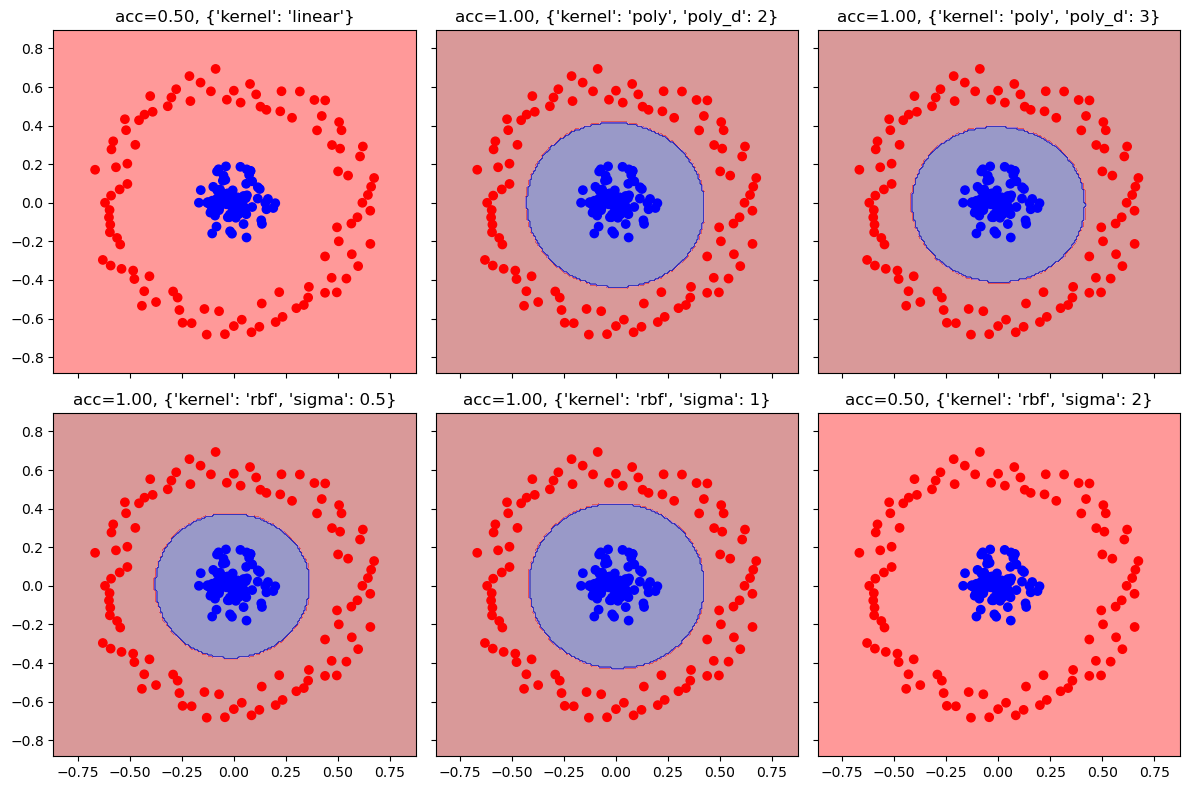

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

param_grid = [
    {'kernel': 'linear'},
    {'kernel': 'poly', 'poly_d': 2},
    {'kernel': 'poly', 'poly_d': 3},
    {'kernel': 'rbf', 'sigma': 0.5},
    {'kernel': 'rbf', 'sigma': 1},
    {'kernel': 'rbf', 'sigma': 2},
]

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
XX, YY = np.meshgrid(np.linspace(x_min, x_max, 200),
                    np.linspace(y_min, y_max, 200))
D = np.vstack((XX.flatten(), YY.flatten())).T

best_acc = 0
best_svm = None
for params, ax in zip(param_grid, axes):
    # pass params dict as **kwargs
    svm = SVM(**params).fit(X, y)

    y_pred = svm.predict(D)
    y_pred = y_pred.reshape(XX.shape)
    acc = np.sum(svm.predict(X) == y)/y.shape[0]
    if acc > best_acc:
        best_acc = acc
        best_svm = svm

    ax.set_title(f"{acc=:.2f}, {params}")
    ax.contourf(XX, YY, y_pred, alpha=.4, cmap='seismic_r')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])

plt.tight_layout()

## Hyperparameter tuning via grid search

((240, 2), (60, 2), (240,), (60,))

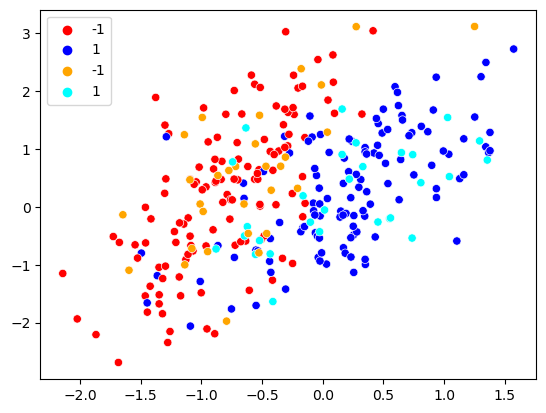

In [1023]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=300, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=0.5
)
y = y*2-1
X = (X - X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette=['r', 'b'])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette=['orange', 'cyan'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [1024]:
svm = SVM().fit(X_train, y_train)
acc = np.sum(svm.predict(X_test) == y_test)/y_test.shape[0]
acc

0.8333333333333334

In [1026]:
from itertools import product

param_grid = [
    {'kernel': ['linear'], 'C': [.1, 1, 10]},
    {'kernel': ['poly'], 'C': [.1, 1, 10], 'poly_d': [2, 3, 7], 'poly_c': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [.1, 1, 10], 'sigma': [0.1, 0.5, 1, 1.5]}
]    

best_acc = 0
best_svm = None

for params in param_grid:
    kws = list(params.keys())
    for param_ranges in product(*params.values()):
        param_config = {kws[i]: val for i, val in enumerate(param_ranges)}

        svm = SVM(**param_config).fit(X_train, y_train)
        acc = np.sum(svm.predict(X_test) == y_test)/y_test.shape[0]
        print(param_config, f"{acc=}", end='')
        if acc > best_acc:
            best_acc = acc
            best_svm = svm
            print(" *** ", end='')
        print()


{'kernel': 'linear', 'C': 0.1} acc=0.8 *** 
{'kernel': 'linear', 'C': 1} acc=0.8166666666666667 *** 
{'kernel': 'linear', 'C': 10} acc=0.8166666666666667
{'kernel': 'poly', 'C': 0.1, 'poly_d': 2, 'poly_c': 0.1} acc=0.7833333333333333
{'kernel': 'poly', 'C': 0.1, 'poly_d': 2, 'poly_c': 1} acc=0.8333333333333334 *** 
{'kernel': 'poly', 'C': 0.1, 'poly_d': 2, 'poly_c': 10} acc=0.8166666666666667
{'kernel': 'poly', 'C': 0.1, 'poly_d': 3, 'poly_c': 0.1} acc=0.7666666666666667
{'kernel': 'poly', 'C': 0.1, 'poly_d': 3, 'poly_c': 1} acc=0.8333333333333334
{'kernel': 'poly', 'C': 0.1, 'poly_d': 3, 'poly_c': 10} acc=0.8
{'kernel': 'poly', 'C': 0.1, 'poly_d': 7, 'poly_c': 0.1} acc=0.7166666666666667
{'kernel': 'poly', 'C': 0.1, 'poly_d': 7, 'poly_c': 1} acc=0.75
{'kernel': 'poly', 'C': 0.1, 'poly_d': 7, 'poly_c': 10} acc=0.0
{'kernel': 'poly', 'C': 1, 'poly_d': 2, 'poly_c': 0.1} acc=0.8166666666666667
{'kernel': 'poly', 'C': 1, 'poly_d': 2, 'poly_c': 1} acc=0.7833333333333333
{'kernel': 'poly', '

In [1027]:
acc = np.sum(best_svm.predict(X_test) == y_test)/y_test.shape[0]
acc, best_svm.kernel

(0.85, 'poly')

## SVM Sklearn

In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

y = y*2-1
X = (X - X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [21]:
cv = StratifiedKFold(n_splits=10)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

svm = SVC()

svm_gscv = GridSearchCV(svm, param_grid, cv=cv).fit(X_train, y_train)

In [22]:
svm_gscv.best_params_

{'C': 0.001, 'gamma': 10, 'kernel': 'poly'}

In [24]:
svm_gscv.best_estimator_.score(X_test, y_test)

0.9385964912280702